In [32]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## PRE

In [33]:
us_change = pd.read_csv("data/us_change.csv")
us_change

,Quarter,Consumption,Income,Production,Savings,Unemployment
0,1970 Q1,0.618566,1.044801,-2.452486,5.299014,0.9
1,1970 Q2,0.451984,1.225647,-0.551459,7.789894,0.5
2,1970 Q3,0.872872,1.585154,-0.358652,7.403984,0.5
3,1970 Q4,-0.271848,-0.239545,-2.185691,1.169898,0.7
4,1971 Q1,1.901345,1.975925,1.909764,3.535667,-0.1
...,...,...,...,...,...,...
193,2018 Q2,0.983112,0.661825,1.117424,-2.723974,0.0
194,2018 Q3,0.853181,0.806271,1.256722,-0.085686,-0.3
195,2018 Q4,0.356512,0.695142,0.948148,5.031337,0.2
196,2019 Q1,0.282885,1.100753,-0.488206,9.760287,-0.1


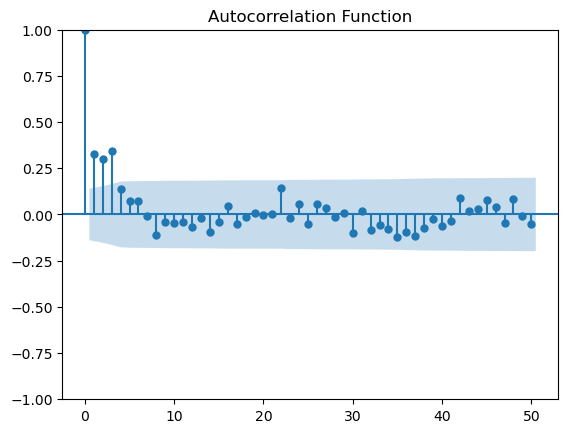

In [34]:
# ACF plot
plot_acf(us_change["Consumption"], lags=50)
plt.title('Autocorrelation Function')
plt.show()

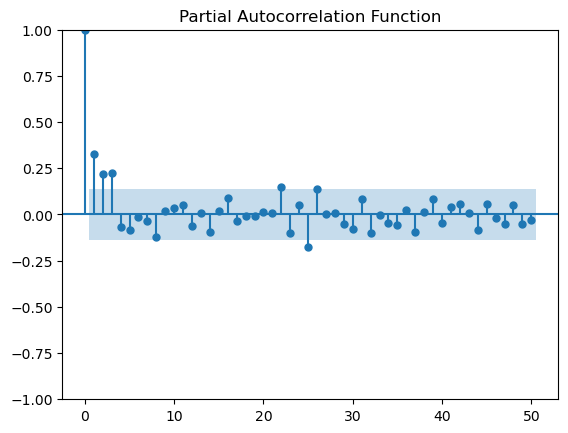

In [35]:
# PACF plot
plot_pacf(us_change["Consumption"], lags=50, method='ywm')  # Use `ywm` or `ols` for consistent results
plt.title('Partial Autocorrelation Function')
plt.show()

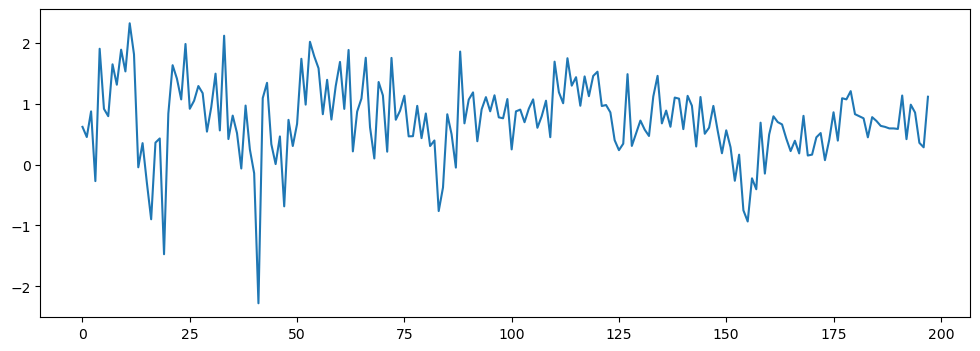

In [36]:
plt.figure(figsize=(12,4))
plt.plot(us_change["Consumption"])

## SARIMA

In [37]:
model = SARIMAX(us_change["Consumption"])
model_fit = model.fit()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04206D+00    |proj g|=  4.46124D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      8      1     0     0   1.300D-07   1.042D+00
  F =   1.0420486501604909     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


### Residuals

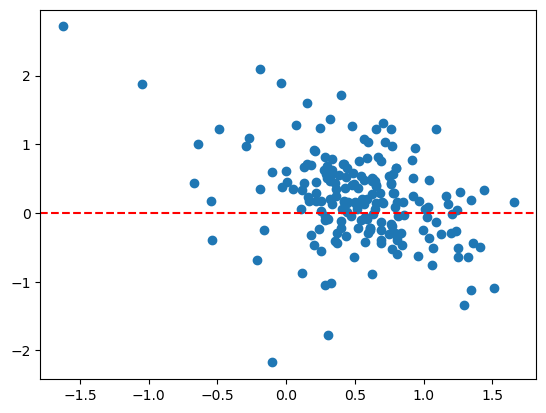

In [38]:
plt.scatter(model_fit.fittedvalues, model_fit.resid)
plt.axhline(0, color="red", linestyle="--")
plt.show()

## SARIMAX

In [39]:
model_x = SARIMAX(us_change["Consumption"], exog=us_change[["Income", "Production", "Savings", "Unemployment"]])
model_x_fit = model_x.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.55519D-01    |proj g|=  5.08580D-01

At iterate    5    f=  3.54794D-01    |proj g|=  2.33283D-01

At iterate   10    f=  3.54462D-01    |proj g|=  1.02140D-01

At iterate   15    f=  3.54254D-01    |proj g|=  5.62128D-02

At iterate   20    f=  3.53999D-01    |proj g|=  9.77177D-03

At iterate   25    f=  3.53990D-01    |proj g|=  4.20827D-02

At iterate   30    f=  3.53970D-01    |proj g|=  7.67785D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


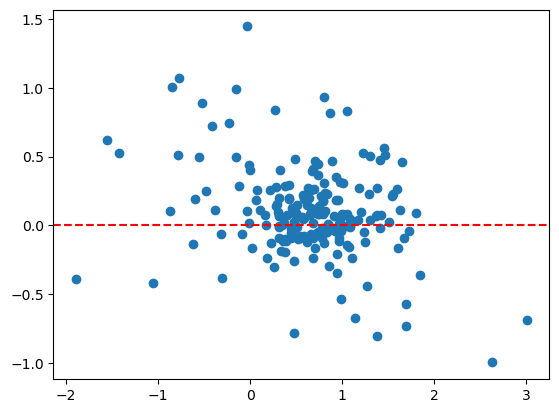

In [40]:
plt.scatter(model_x_fit.fittedvalues, model_x_fit.resid)
plt.axhline(0, color="red", linestyle="--")
plt.show()

# Metrics